In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [364]:
df = pd.DataFrame()

sensor1=np.loadtxt("sensor_data1.txt", delimiter=",")
sensor2=np.loadtxt("sensor_data2.txt", delimiter=",")

if len(sensor1) >= len(sensor2):
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")[:len(sensor2)]
else:
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")[:len(sensor1)]
    

In [365]:
#descartar primeras 1500 mediciones por sensiblidad de los sensores
df = df[1500:]

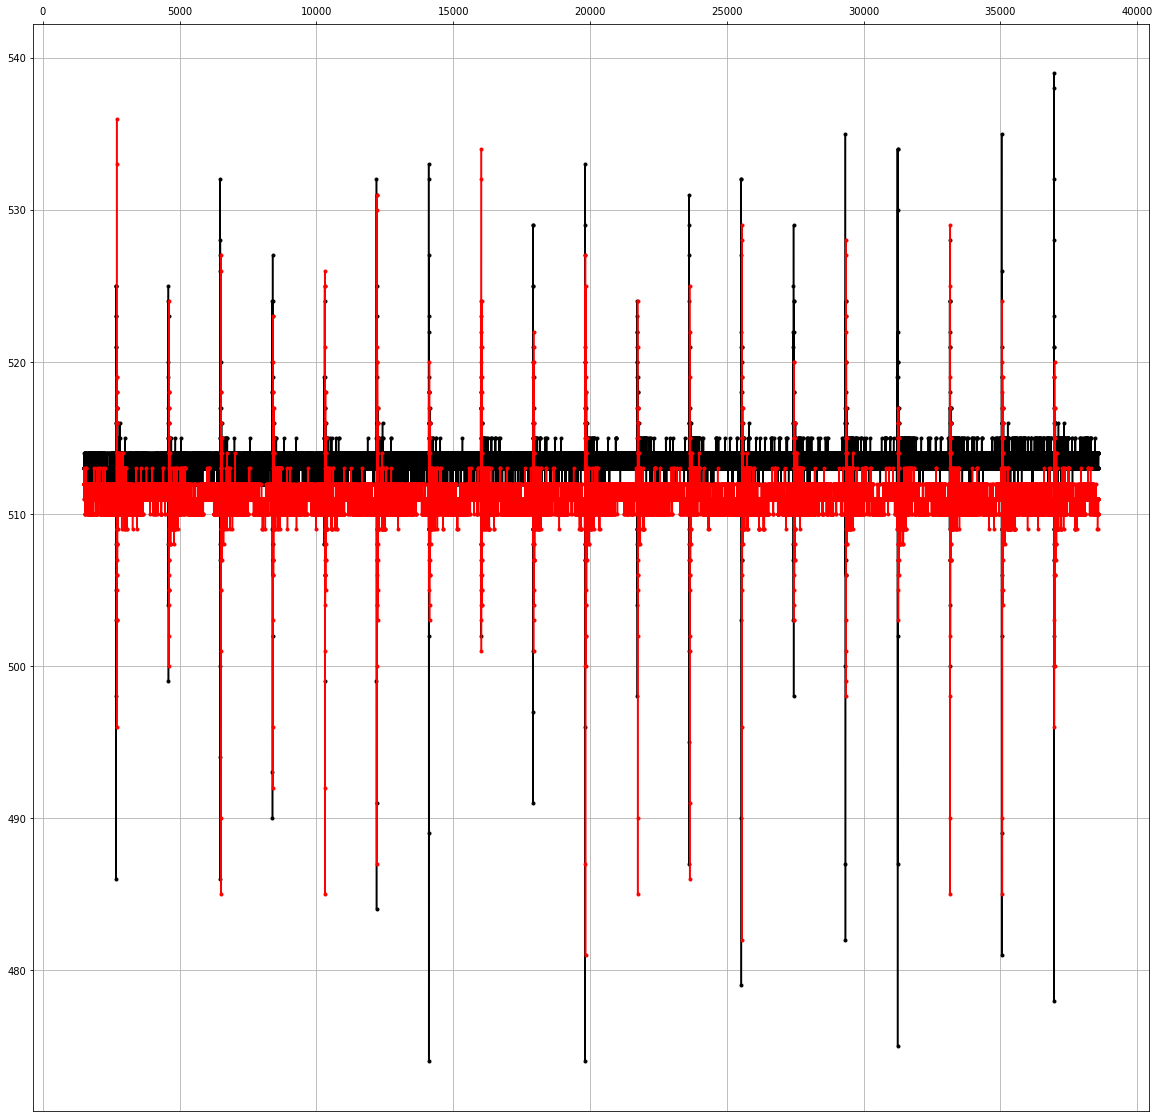

In [366]:
ax = plt.gca()
ax.xaxis.tick_top()
ax.plot(df.index, df["sensor1"], "k.-")
ax.plot(df.index, df["sensor2"], "r.-")
ax.grid()
fig = plt.gcf()
fig.set_size_inches(20, 20)
#x lim
a=4000
b=5000
#plt.xlim(0, 2000)

In [367]:
# n_mediciones_pico = abs(df.iloc[a:b, 0].idxmax()- df.iloc[a:b, 1].idxmax())
# n_mediciones_valle = abs(df.iloc[a:b, 0].idxmin()- df.iloc[a:b, 1].idxmin())
# n_mediciones_pico, n_mediciones_valle

In [368]:
# tiempo_pico = n_mediciones_pico*3/11369
# tiempo_valle = n_mediciones_valle*3/11369
# tiempo_pico, tiempo_valle

In [369]:
# distancia= 0.6
# distancia/tiempo_pico, distancia/tiempo_valle

In [370]:
# (distancia/tiempo_pico + distancia/tiempo_valle)/2


In [371]:
#import k-means
from sklearn.cluster import KMeans
df = df.reset_index().rename(columns={"index": "time"})

In [372]:
df

,time,sensor2,sensor1
0,1500,511.0,513.0
1,1501,512.0,513.0
2,1502,512.0,513.0
3,1503,512.0,513.0
4,1504,511.0,513.0
...,...,...,...
37082,38582,511.0,513.0
37083,38583,511.0,514.0
37084,38584,511.0,514.0
37085,38585,511.0,513.0


In [373]:
#identify 20 groups in df_sensor1 by k-means taking time and values into account
kmeans_sensor1 = KMeans(n_clusters=20, random_state=0).fit(df[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=20, random_state=0).fit(df[["time", "sensor2"]])

#write the clasification for each row in df_sensor1
df["sensor1_pulse"]=kmeans_sensor1.labels_
df["sensor2_pulse"]=kmeans_sensor2.labels_

In [374]:
df.query("sensor1_pulse == 0")["sensor1"].idxmax(), df.query("sensor2_pulse == 0")["sensor2"].idxmax()

(12601, 12630)

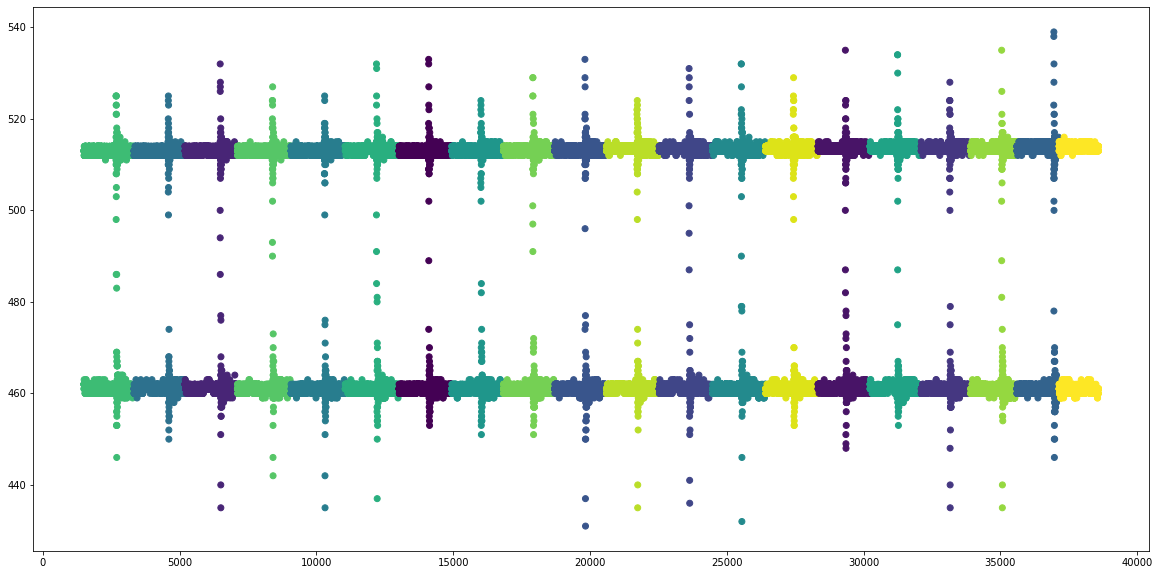

In [376]:
#plot the clasification
plt.figure(figsize=(20, 10))
plt.scatter(df["time"], df["sensor1"], c=df["sensor1_pulse"])
plt.scatter(df["time"], df["sensor2"] - 50, c=df["sensor2_pulse"])
#plt.xlim(4000, 5000)
plt.show()


In [377]:
df.query("sensor1_pulse == 4")["sensor1"].idxmax(), df.query("sensor2_pulse == 4")["sensor2"].idxmax()

(22121, 22141)

In [378]:
#identify the time of the peak for each group
#peaks_sensor1 = 
peaks1 = df[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})
peaks2 = df[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})
peaks = pd.merge(peaks1, peaks2, on="pulse")

In [379]:
abs(peaks["sensor1"] - peaks["sensor2"]).mean(), abs(peaks["sensor1"] - peaks["sensor2"]).std()

(23.25, 12.80984407645768)

In [380]:
time = abs(peaks["sensor1"] - peaks["sensor2"]).mean()*3/11369
distance = 0.6
speed = distance/time

In [381]:
speed

97.79784946236558